
========== Random Forest Final Results ==========
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1083
           1       0.50      0.17      0.25         6

    accuracy                           0.99      1089
   macro avg       0.75      0.58      0.62      1089
weighted avg       0.99      0.99      0.99      1089



<Figure size 1000x800 with 0 Axes>

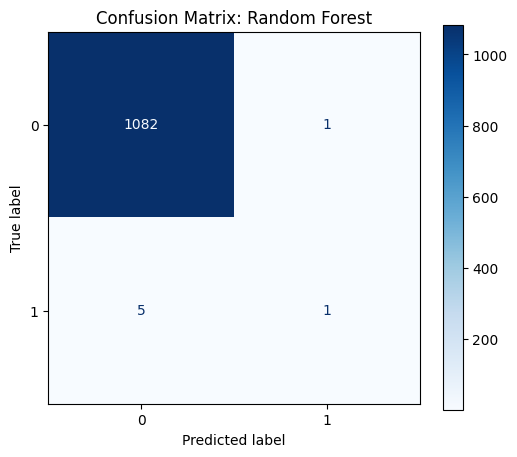


========== XGBoost Final Results ==========
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1083
           1       0.75      0.50      0.60         6

    accuracy                           1.00      1089
   macro avg       0.87      0.75      0.80      1089
weighted avg       1.00      1.00      1.00      1089



d:\D\Infoysys-internship\ExoHabitAI\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:05:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


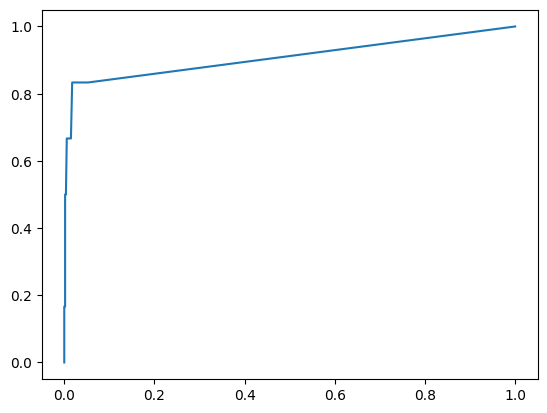

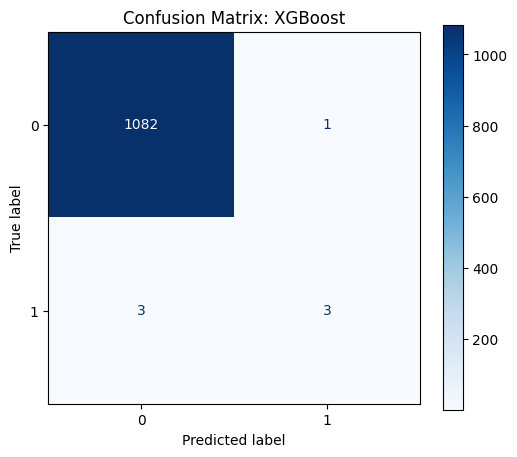

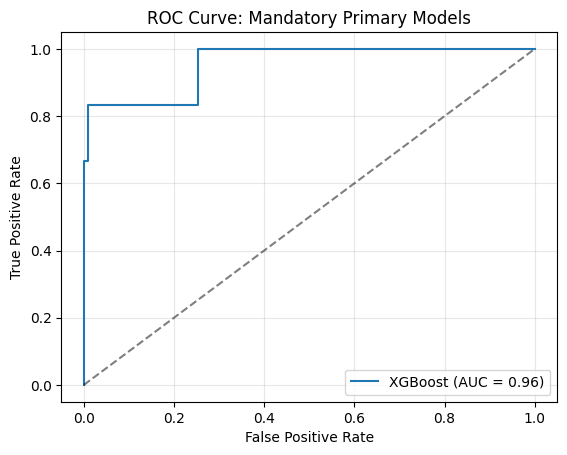


--- Mandatory Model Comparison Summary ---
           Model  Accuracy  Precision    Recall  F1-score
0  Random Forest  0.994490       0.50  0.166667      0.25
1        XGBoost  0.996327       0.75  0.500000      0.60


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
)

if not os.path.exists('models'):
    os.makedirs('models')
    
# 1. LOAD FINAL PREPARED DATA
X_train = pd.read_csv('X_train_final.csv')
y_train = pd.read_csv('y_train_final.csv').values.ravel()
X_test = pd.read_csv('X_test_final.csv')
# Binarizing the test target for classification evaluation (Threshold: 0.7)
y_test_cont = pd.read_csv('y_test_final.csv').values.ravel()
y_test = (y_test_cont > 0.7).astype(int)

# 2. INITIALIZE PRIMARY MODEL PIPELINES
# Using mandatory models as per mentor's document [cite: 39, 43]
rf_pipe = Pipeline([
    ('scaler', StandardScaler()), # Scaling strategy [cite: 50, 51]
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# 3. TRAINING & EVALUATION LOOP
primary_models = {
    "Random Forest": rf_pipe,
    "XGBoost": xgb_pipe
}

# Preparing to store metrics for final comparison [cite: 68, 69]
model_performance = []

plt.figure(figsize=(10, 8)) # Setup for ROC Curve [cite: 73]

for name, pipe in primary_models.items():
    # Model Training [cite: 60]
    pipe.fit(X_train, y_train)
    
    # Model Storage [cite: 62, 64]
    joblib.dump(pipe, f'models/{name.lower().replace(" ", "_")}.pkl')
    
    # Predictions
    y_pred = pipe.predict(X_test)
    y_probs = pipe.predict_proba(X_test)[:, 1] # Used for ranking [cite: 96]
    
    # Calculate Metrics 
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }
    model_performance.append(metrics)
    
    # Mandatory Outputs: Classification Report & Confusion Matrix [cite: 71, 72]
    print(f"\n{'='*10} {name} Final Results {'='*10}")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', ax=ax)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # Calculate ROC Curve [cite: 73]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Finalize Mandatory ROC Plot [cite: 73]
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Mandatory Primary Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# 4. MODEL COMPARISON SUMMARY [cite: 87, 88]
comparison_df = pd.DataFrame(model_performance)
print("\n--- Mandatory Model Comparison Summary ---")
print(comparison_df)